# Simulation - Projet

## Importation des modules nécessaires


In [56]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import math

## Lecture du fichier d'entrée

In [57]:
def e_numbers():
    with open("exp.txt", "r") as e:
        for line in e:
            line = line.strip()
            if "." in line:
                line = line.split(".")[1]
            for c in line:
                yield int(c)

e_numbers = np.array(list(e_numbers()))
print(f'Les 2.000.000 premières décimales d\' exp :\n {e_numbers}')

Les 2.000.000 premières décimales d' exp :
 [7 1 8 ... 0 2 3]


## Compter effectif

In [58]:
def count_number(data):
    values, counts = np.unique(data, return_counts=True)
    return values, counts

e_labels, e_counts = count_number(e_numbers)
print(f'Les chiffres apparaissant dans les décimales d\' exp : \n {e_labels}')
print(f'Leur fréquences d\'apparition : \n {e_counts}')

Les chiffres apparaissant dans les décimales d' exp : 
 [0 1 2 3 4 5 6 7 8 9]
Leur fréquences d'apparition : 
 [199093 200171 199471 200361 199923 200285 200395 199789 200098 200414]


## Construire histogramme


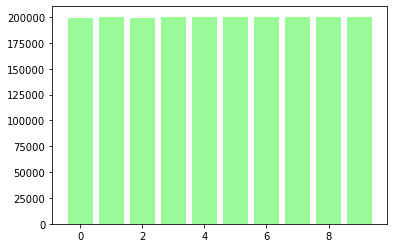

In [59]:
def construct_hist(labels, counts):
    fig, ax = plt.subplots()
    ax.bar(labels, counts, color='palegreen')
    plt.show()

construct_hist(e_labels, e_counts)

## Test du Chi-Carré

In [60]:
def chi_squared_uniform(counts):
    pi = 1 / len(counts)
    N = sum(counts)
    kr = np.sum(((counts-(N*pi))/(math.sqrt(N*pi)))**2)
    critical = stat.chi2.ppf(q=0.95, df=9)
    return kr <= critical, kr, critical

print(f'Le résultat de notre test du Chi-Carré est : \n {chi_squared_uniform(e_counts)}')

Le résultat de notre test du Chi-Carré est : 
 (True, 8.65376, 16.918977604620448)


In [109]:
def split_in_groups(data, groups=10):
    data = np.sort(data)
    res = [data[np.where(np.logical_and(data < i, data > i-(1/groups)))] for i in np.arange(0, 1, 1/groups)]
    return np.array(res)

In [74]:
def chi_squared_continuous(data, groups=10):
    splitted = split_in_groups(data, groups)
    print(splitted)
    _, counts = count_number(splitted)
    return chi_squared_uniform(counts)


## Test de Kolmogorov-Smirnov

In [62]:
def kolmogorov_smirnov(labels, counts):
    assert len(labels) == len(counts)
    proba = 1 / len(counts)
    N = np.sum(counts)
    real_repartition = np.cumsum(counts, axis=0)/N
    th_repartition = np.cumsum(np.full(len(labels), proba))
    maximum = np.max(np.abs(real_repartition-th_repartition))
    critical = 1.358/math.sqrt(N/len(labels))
    return maximum < critical, maximum, critical

print(kolmogorov_smirnov(e_labels, e_counts))

(True, 0.0006325000000000358, 0.0030365803134447147)


## Test du Poker

In [63]:
def poker_test(data, labels, counts):
    number_lists = len(data)/4
    lists = np.split(data, number_lists)
    all_diff = 0
    one_pair = 0
    two_pair = 0
    triplet = 0
    quadr = 0
    for li in lists:
        vals, cts = np.unique(li, return_counts=True)
        if len(cts) == 4:
            all_diff += 1
        elif len(cts) == 3:
            one_pair += 1
        elif len(cts) == 2:
            if 3 in cts:
                triplet += 1
            else:
                two_pair += 1
        else:
            quadr += 1
    return chi_squarred_poker(np.array([all_diff, one_pair, triplet, two_pair, quadr]), len(lists))

def chi_squarred_poker(observed, N):    # P(all_diff) > P(one_pair) > P(triplet) > P(two_pair) > P(quadr)
    probas = np.array([0.504, 0.432, 0.036, 0.027, 0.001])
    theorical = probas * N
    kr = np.sum(((observed-theorical)**2)/theorical)
    critical = stat.chi2.ppf(q=0.95, df=4)
    return kr <= critical, kr, critical

print(poker_test(e_numbers, e_labels, e_counts))

(True, 1.2631547619047618, 9.487729036781154)


## Test du gap

In [64]:
def gap_test(data, a: int = 0, b: int = 5, total_numbers: int = 10):
    assert a < b
    probability = (b - a) / total_numbers  # => proba 1/2 d'être marqué
    intervals = []
    length_series_not_in = 0
    total_gaps = 0
    sequence_length = 0
    for nb in data:
        if a <= nb < b:
            # nb in interval, with probability `probability`
            intervals.append(length_series_not_in)
            length_series_not_in = 1
        else:
            # nb not in interval
            length_series_not_in += 1
            total_gaps += 1
        sequence_length += 1
    labels, observed = np.unique(np.array(intervals), return_counts=True)
    observed = np.cumsum(complete_labels(labels, observed)/sequence_length)
    theorical = np.cumsum(np.array([probability ** (n + 1) for n in range(max(labels))]))
    kr = np.sum(((observed - theorical) ** 2) / theorical)
    crit = stat.chi2.ppf(q=0.05, df=len(observed) - 1)
    return kr <= crit, kr, crit

def complete_labels(labels, observed):
    i = 1
    j = 0
    n = 1
    res = []
    while j < len(labels):
        label = labels[j]
        if i != label:
            res.append(0)
            n += 1
        else:
            res.append(observed[i-n])
            j += 1
        i += 1
    return np.array(res)

gap_test(e_numbers)

(True, 5.5117785465143285, 12.338014578790643)

## Generateur

In [65]:
NB_DIGITS = 10

def generator(n: int = 1, seed_: int = 0):
    for i in range(n):
        xyz = []
        for j in range(3):
            digits = []
            for k in range(NB_DIGITS):
                seed = e_numbers[seed_ + i + j + k]
                a = len(e_numbers) - seed
                c = e_numbers[i + seed]
                digit = (a * seed + c) % 10
                digits.append(digit)
            xyz.append(float("0." + "".join(map(lambda x: str(x), digits))))
        yield math.sqrt(sum([x**2 for x in xyz]))/math.sqrt(3)

gen = list(generator(1000, 50))
print(count_number(gen))

(array([0.01348708, 0.02044921, 0.04138264, 0.04480176, 0.04509058,
       0.06131286, 0.06384784, 0.06505924, 0.06897072, 0.08270355,
       0.08659128, 0.08699869, 0.08962471, 0.0901702 , 0.09020989,
       0.1047679 , 0.11651312, 0.11772134, 0.11812199, 0.11923993,
       0.12390378, 0.12398829, 0.1263874 , 0.12845626, 0.14091753,
       0.14179561, 0.14565377, 0.15902743, 0.16563457, 0.16919567,
       0.17344118, 0.17407069, 0.17484663, 0.17535502, 0.1770225 ,
       0.17719936, 0.18011637, 0.18202752, 0.182279  , 0.19245637,
       0.19324475, 0.1985417 , 0.19864917, 0.20550513, 0.20583296,
       0.20795859, 0.20812427, 0.21165769, 0.21659397, 0.22127388,
       0.22297014, 0.22315214, 0.22365045, 0.22470865, 0.22799615,
       0.23105471, 0.23152441, 0.23397062, 0.23405208, 0.23781466,
       0.23886119, 0.24026377, 0.24381381, 0.24479911, 0.24578935,
       0.24592262, 0.24701884, 0.24902068, 0.25061821, 0.25461954,
       0.25485065, 0.25714641, 0.25763052, 0.25886414, 0.2590

In [66]:
## Test de notre générateur

In [71]:
lst = list(generator(1000, 50))
print(chi_squared_continuous(lst))

[array([0.01348708, 0.02044921, 0.04138264, 0.04480176, 0.04509058,
       0.06131286, 0.06384784, 0.06505924, 0.06897072, 0.08270355,
       0.08659128, 0.08699869, 0.08962471, 0.0901702 , 0.09020989,
       0.1047679 , 0.11651312, 0.11772134, 0.11812199, 0.11923993,
       0.12390378, 0.12398829, 0.1263874 , 0.12845626, 0.14091753,
       0.14179561, 0.14565377, 0.15902743, 0.16563457, 0.16919567,
       0.17344118, 0.17407069, 0.17484663, 0.17535502, 0.1770225 ,
       0.17719936, 0.18011637, 0.18202752, 0.182279  , 0.19245637,
       0.19324475, 0.1985417 , 0.19864917, 0.20550513, 0.20583296,
       0.20795859, 0.20812427, 0.21165769, 0.21659397, 0.22127388,
       0.22297014, 0.22315214, 0.22365045, 0.22470865, 0.22799615,
       0.23105471, 0.23152441, 0.23397062, 0.23405208, 0.23781466,
       0.23886119, 0.24026377, 0.24381381, 0.24479911, 0.24578935,
       0.24592262, 0.24701884, 0.24902068, 0.25061821, 0.25461954,
       0.25485065, 0.25714641, 0.25763052, 0.25886414, 0.2590

## Petit histogramme

In [110]:
split_in_groups(lst)

<ipython-input-109-aee1738b1e70>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(res)


array([array([], dtype=float64),
       array([0.01348708, 0.02044921, 0.04138264, 0.04480176, 0.04509058,
              0.06131286, 0.06384784, 0.06505924, 0.06897072, 0.08270355,
              0.08659128, 0.08699869, 0.08962471, 0.0901702 , 0.09020989]),
       array([0.1047679 , 0.11651312, 0.11772134, 0.11812199, 0.11923993,
              0.12390378, 0.12398829, 0.1263874 , 0.12845626, 0.14091753,
              0.14179561, 0.14565377, 0.15902743, 0.16563457, 0.16919567,
              0.17344118, 0.17407069, 0.17484663, 0.17535502, 0.1770225 ,
              0.17719936, 0.18011637, 0.18202752, 0.182279  , 0.19245637,
              0.19324475, 0.1985417 , 0.19864917])                       ,
       array([0.20550513, 0.20583296, 0.20795859, 0.20812427, 0.21165769,
              0.21659397, 0.22127388, 0.22297014, 0.22315214, 0.22365045,
              0.22470865, 0.22799615, 0.23105471, 0.23152441, 0.23397062,
              0.23405208, 0.23781466, 0.23886119, 0.24026377, 0.24381381,
  

<ipython-input-109-aee1738b1e70>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(res)


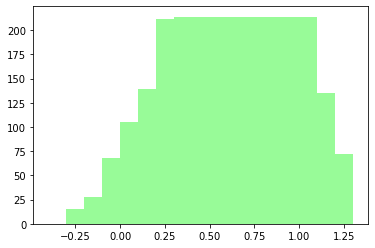

In [115]:
l = split_in_groups(lst)
fig, ax = plt.subplots()
ax.bar(np.arange(0, 1, 0.1), list(map(lambda x: len(x), l)), color='palegreen')
plt.show()